#  SWB211 Project 
##### Prepared by SWB Team: Tyler Will, Stefanie Senger, Fracisco Avalos Jr., Won Fy Lee

## Executive Summary
* ### Identify eligible candidates to the Kansas City Scholars (KCS) program in the Kansas City metropolitan area. 
* ### The U.S. census and survey data used was found as close as possible to match the eligibility requirements of KCS applicants.
* ### Considerations on the findings given the approach is to be discussed:
    * ### Block-level Map of following features
        * #### Number of eligible population.
        * #### Population Density (Number of eligible population per sq mile).
        * #### Hot Spot Geospatial Analysis that shows statistically significant high/low density areas.

# Introduction

The goal of this project is to estimate the spatial distribution of Great Jobs KC eligible population using as fine-grained data as possible. 

An individual is eligible for Great Jobs KC if:

 1. 18 years or older ✅

 2. Live in one of the six eligible counties (KS: Wyandotte, Johnson; Missouri: Cass, Clay, Jackson, Platte) ✅

 3. Low or modest income evidenced by current earnings of less than $45,000 annually✅

 4. Has not previously earned a bachelor’s degree✅

 5. Has not previously been awarded a KC Scholarship (Traditional or Adult Learner)❓

 6. Not a current KC Scholars college scholarship awardee.❓

 7. Lawfully present in the United States or DACA eligible and DACA applied/approved.❓

### Data 

The lowest-level geography data available from Census is block-level. A census block in KC have an average population of 21. In terms of relative size, a census tract contains 70 blocks and a census block-group contains an average of 23 blocks. Despite the small size of the block, only total population count information is available at the block-level. 


The lowest-level geography data available for #1, #3 and #4 is block-group from 2021 American Community Survey. In addition, only marginal information of %age, %income and %education is available, while the information we need to define eligible population is joint density of %age*%income*%education. 

### Method

In order to derive the joint density, we assume variable independence (Assumption 1):

 \begin{align}
 P(I,E,A|bg)=P(I|bg)P(E|bg)Pr(A|bg)
  \label{eq1}\tag{1} \\
 \end{align}
 
 In order to leverage both block and block-group level data available, we consolidate the data from two different levels of geography by assuming that populations in blocks within a same block-group share same %age, %income and %education defined at the block-group, while respecting the total population counts defined at the block-level (Assumption 2):
 
 \begin{align}
         N(I, E, A|b,bg) = P(I,E,A|bg)*N(b|bg)
  \label{eq2}\tag{2} \\
 \end{align}
 
#### Adjustment to Assumption 1:

We found high correlation between \%income and \% education (~= 0.9). To adjust high correlation between \% low income and \% education lt BA, we run a simple bivariate linear regression with independent variable (X) defined as \% annual income less than 45,000 dollars and dependent variable (Y) set as \% population with less than bachelors degree. We use \% education instead of \%income as dependent variable, simply because the \% low education is much higher than the \% income less than 45k (63\% vs 54\%). The predicted value out of this regression gives us an adjusted share for Pr(I|bg) that account for the correlation between the two variable and it is strictly larger than the original Pr(I|bg).


\begin{align}
\underbrace{\hat{Y}}_{\%education} =\underbrace{\alpha}_{intercept} + \underbrace{\beta}_{slope} * \underbrace{X}_{\%income} +\underbrace{\epsilon}_{error}  \label{eq3}\tag{3} \\
 \end{align}
 

See Sections 9 - 13.

### Preliminary Results




 



In [15]:
%%html
<table style="font-size:0.8em">
    	<thead><tr>
            <th>County</th>
            <th>N CensusTract</th>            
            <th>N BlockGroup</th>
            <th>N Block</th>
            <th>Blocks per BG</th> 

        </tr></thead>
        <tbody><tr>
            <td>Cass</td>
            <td>24</td>            
            <td>83</td>
            <td>3571</td>
            <td>43</td> 

        </tr>
        <tr>
            <td>Clay</td>
            <td>55</td>
            <td>192</td>
            <td>5222</td>
            <td>27</td> 

        </tr>
        <tr>
            <td>Jackson</td>
            <td>227</td>
            <td>640</td>
            <td>14842</td>
             <td>23</td> 
           
        </tr>
        <tr>
            <td>Johnson</td>
            <td>154</td>
            <td>462</td>
            <td>8235</td>
            <td>18</td> 
            
        </tr>
        <tr>
            <td>Platte</td>
            <td>26</td>
            <td>80</td>
            <td>2475</td>
            <td>31</td> 
            
        </tr>
        <tr>
            <td>Wyandotte</td>
            <td>64</td>
            <td>165</td>
            <td>3355</td>
            <td>20</td> 
            
        </tr>    
        <tr>
            <td>Total</td>
            <td>550</td>
            <td>1622</td>
           <td>37700</td>
            <td>23</td> 
            
        </tr>              
    </tbody>
</table>

County,N CensusTract,N BlockGroup,N Block,Blocks per BG
Cass,24,83,3571,43
Clay,55,192,5222,27
Jackson,227,640,14842,23
Johnson,154,462,8235,18
Platte,26,80,2475,31
Wyandotte,64,165,3355,20
Total,550,1622,37700,23



## Joint Density Calculation
### Data downloaded from https://www.nhgis.org/

- 2020 Census, Block level
  - Total Population Counts
- 2021 American Community Survey: 5-Year Data, Block-group level
  - Counts by age
  - Counts by education 
  - Counts by earnings




### 1. Imports

In [21]:
import pandas as pd 
import os

### Path Management
using [`os.path.join`](https://docs.python.org/3/library/os.path.html), to fit the paths for Linux/MacOS and Windows syntax, which is more robust:
* Linux/MacOS syntax (e.g. `../folder_name`) 
* and Windows syntax (e.g. `..\\folder_name`) 

In [22]:
wd='/Users/wonfylee/Library/CloudStorage/GoogleDrive-leex5089@umn.edu/My Drive/0.SWB/SWB211'

csv_path_population_block = os.path.join(wd, 'census_data', 'nhgis0202_csv', 'nhgis0202_ds248_2020_block.csv')
csv_path_education_income = os.path.join(wd, 'census_data', 'nhgis0197_csv', 'nhgis0197_ds254_20215_blck_grp.csv')
csv_path_personal_income = os.path.join(wd, 'census_data', 'nhgis0205_csv', 'nhgis0205_ds254_20215_blck_grp.csv')

csv_path_age = os.path.join(wd, 'census_data', 'nhgis0203_csv', 'nhgis0203_ds254_20215_blck_grp.csv')

dta_path_6_counties = os.path.join(wd, 'intermediate_data', 'b_KC_6counties.dta')
dta_path_county_crosswalk = os.path.join(wd, 'intermediate_data', 'b_bg_county_crosswalk.dta')

### 2. DataFrame of population count per house block
#### [Download block-level Data](https://drive.google.com/file/d/1PpBdZLxjuU8gYFRaH1YH8Mo_jQyvucTD/view?usp=share_link)
#### [Download codebook](https://drive.google.com/file/d/1Q07GfUr7E_S7Of81rsdNRAorfGjtKotN/view?usp=share_link)


In [23]:
block_raw = pd.read_csv(csv_path_population_block, low_memory=False)
block_raw.columns = block_raw.columns.str.lower()
 
block_data = block_raw[['gisjoin', 'state','county','u7b001']]
block_data = block_data.rename(columns={'gisjoin': 'b_gisjoin'})                
block_data = block_data.rename(columns={'u7b001': 'b_population'}) # b_target_pop: Block level estimate of total population.

block_data            
block_data['b_population'].mean()

21.33652070461633

### 3. DataFrame of household income and individual's educational status accumulated per block group
A block group is a collection of several house blocks; approximatly 30-50 blocks form a block group.
#### [Download block group-level Data](https://drive.google.com/file/d/1Pk3rLOX4K3efD69GoOQ5lFa2apiqGJPM/view?usp=share_link  )
#### [Download codebook](https://drive.google.com/file/d/1PfbiBFwF5PAS1Kq6Fdy8_6klsqOxRE5b/view?usp=share_link)

Note: We use personal earnings data instead of household income in the analysis.


In [24]:
blockgroup_raw = pd.read_csv(csv_path_education_income)
blockgroup_raw.columns = blockgroup_raw.columns.str.lower()
col_list=blockgroup_raw[['aop8e002', 'aop8e003', 'aop8e004', 'aop8e005', 'aop8e006', 'aop8e007', 'aop8e008' ,'aop8e009', 'aop8e010', 'aop8e011', 'aop8e012', 'aop8e013', 'aop8e014', 'aop8e015', 'aop8e016', 'aop8e017', 'aop8e018', 'aop8e019', 'aop8e020', 'aop8e021']]
blockgroup_raw['bg_educ_lt_bachelors']=col_list.sum(axis=1) # summing population count below bachelor's degree
col_list=blockgroup_raw[['aoqhe002', 'aoqhe003', 'aoqhe004', 'aoqhe005', 'aoqhe006', 'aoqhe007', 'aoqhe008', 'aoqhe009']]
blockgroup_raw['bg_inc_lt_45000']=col_list.sum(axis=1) # summing housdhold inclome below 45 k

blockgroup_raw['s_bg_educ_lt_bachelors']=blockgroup_raw['bg_educ_lt_bachelors']/blockgroup_raw['aop8e001'] # percentage of non-BA's over whole population (creates Nan values where the population per block group is 0)
blockgroup_raw['s_bg_inc_lt_45000']=blockgroup_raw['bg_inc_lt_45000']/blockgroup_raw['aoqhe001'] # percentage of low earning households over all housholds (creates Nan values where the population per block group is 0)
blockgroup_raw = blockgroup_raw.rename(columns={'gisjoin': 'bg_gisjoin'})                
bg_educ_inc=blockgroup_raw[['bg_gisjoin', 'bg_educ_lt_bachelors','bg_inc_lt_45000','s_bg_educ_lt_bachelors','s_bg_inc_lt_45000']]

bg_educ_inc

,bg_gisjoin,bg_educ_lt_bachelors,bg_inc_lt_45000,s_bg_educ_lt_bachelors,s_bg_inc_lt_45000
0,G20000109526001,1146,195,0.861007,0.281792
1,G20000109527001,548,210,0.734584,0.466667
2,G20000109527002,527,110,0.780741,0.303867
3,G20000109528001,521,240,0.785822,0.551724
4,G20000109528002,650,252,0.672878,0.464945
...,...,...,...,...,...
7487,G29051001277001,661,211,0.937589,0.703333
7488,G29051001277002,654,289,1.000000,0.865269
7489,G29051001277003,176,79,0.752137,0.576642
7490,G29051001278001,959,982,0.762928,0.891916


### 4. DataFrame of population's age accumulated per block group
#### [Download block group-level Data](https://drive.google.com/file/d/1Q5OGL-dRmYbJO7Q8WGjSahMS3s1QBnAI/view?usp=share_link )
#### [Download codebook](https://drive.google.com/file/d/1Q7LJjJytZHH-n66zZ5RvwTxnMIus9lLX/view?usp=share_link)

A block group is a collection of several house blocks; approximatly 30-50 blocks form a block group.

In [25]:
blockgroup_raw = pd.read_csv(csv_path_age)
blockgroup_raw.columns = blockgroup_raw.columns.str.lower()
blockgroup_raw.describe()
print(blockgroup_raw.info())
blockgroup_raw.dtypes 
col_list=blockgroup_raw[['aonte007', 'aonte008', 'aonte009', 'aonte010', 'aonte011', 'aonte012', 'aonte013', 'aonte014', 'aonte015', 'aonte016' ,'aonte017', 'aonte018', 'aonte019' ,'aonte020', 'aonte021', 'aonte022', 'aonte023' ,'aonte024' ,'aonte025' ,'aonte031' ,'aonte032', 'aonte033', 'aonte034' ,'aonte035', 'aonte036', 'aonte037', 'aonte038', 'aonte039', 'aonte040', 'aonte041', 'aonte042', 'aonte043', 'aonte044', 'aonte045', 'aonte046', 'aonte047', 'aonte048', 'aonte049']]
blockgroup_raw['bg_age_gt18']=col_list.sum(axis=1) # summing population count 18 years and older
blockgroup_raw['s_bg_age_gt18']=blockgroup_raw['bg_age_gt18']/blockgroup_raw['aonte001'] # percentage of population 18 years and older over whole population (creates Nan values where the population per block group is 0)
blockgroup_raw = blockgroup_raw.rename(columns={'gisjoin': 'bg_gisjoin'})
bg_age=blockgroup_raw[['bg_gisjoin', 'bg_age_gt18','s_bg_age_gt18']]

bg_age

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7492 entries, 0 to 7491
Columns: 1001 entries, gisjoin to aoslm036
dtypes: float64(76), int64(917), object(8)
memory usage: 57.2+ MB
None


,bg_gisjoin,bg_age_gt18,s_bg_age_gt18
0,G20000109526001,1415,0.769859
1,G20000109527001,845,0.795669
2,G20000109527002,726,0.823129
3,G20000109528001,841,0.819688
4,G20000109528002,1221,0.822222
...,...,...,...
7487,G29051001277001,747,0.772492
7488,G29051001277002,784,1.000000
7489,G29051001277003,318,0.736111
7490,G29051001278001,1598,0.820329


### 5. DataFrame of population's personal income (earnings) per block group
#### [Download block group-level Data](https://drive.google.com/file/d/1v8Fl1LpxaeQ13p56kd8M9Byug0cOKqZi/view?usp=share_link)
#### [Download codebook](https://drive.google.com/file/d/1v8YW6t1JpYowCY-O74lx4n1FbRZbboXe/view?usp=share_link)
Table: B20001. Sex by Earnings in the Past 12 Months (in 2021 Inflation-Adjusted Dollars) for the Population 16 Years and Over with Earnings in the Past 12 Months

Universe: Population 16 years and over with earnings

#### Earnings
As noted above, in Census Bureau terminology, earnings are a subset of income. Specifically, earnings are wages or salary from a job, or income from being self-employed. Other kinds of income, not included in earnings, include social security payments, interest and dividends, income from property rental, pensions, public assistance, and child support.
 

In [26]:
blockgroup_raw = pd.read_csv(csv_path_personal_income)
blockgroup_raw.columns = blockgroup_raw.columns.str.lower()
blockgroup_raw.describe()
print(blockgroup_raw.info())
blockgroup_raw.dtypes 
col_list=blockgroup_raw[['aor6e003', 'aor6e004', 'aor6e005', 'aor6e006', 'aor6e007', 'aor6e008', 'aor6e009', 'aor6e010', 'aor6e011', 'aor6e012', 'aor6e013', 'aor6e014', 'aor6e015', 'aor6e016', 'aor6e024' ,'aor6e025', 'aor6e026', 'aor6e027', 'aor6e028', 'aor6e029', 'aor6e030', 'aor6e031', 'aor6e032', 'aor6e033', 'aor6e034', 'aor6e035', 'aor6e036', 'aor6e037']]
blockgroup_raw['bg_pinc_lt_45k']=col_list.sum(axis=1) # summing population count 18 years and older
blockgroup_raw['s_bg_pinc_lt_45k']=blockgroup_raw['bg_pinc_lt_45k']/blockgroup_raw['aor6e001'] # percentage of population 18 years and older over whole population (creates Nan values where the population per block group is 0)
blockgroup_raw = blockgroup_raw.rename(columns={'gisjoin': 'bg_gisjoin'})
bg_personal_income=blockgroup_raw[['bg_gisjoin', 'bg_pinc_lt_45k','s_bg_pinc_lt_45k']]

bg_personal_income

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7492 entries, 0 to 7491
Columns: 129 entries, gisjoin to aor6m043
dtypes: float64(30), int64(91), object(8)
memory usage: 7.4+ MB
None


,bg_gisjoin,bg_pinc_lt_45k,s_bg_pinc_lt_45k
0,G20000109526001,523,0.561159
1,G20000109527001,444,0.805808
2,G20000109527002,324,0.642857
3,G20000109528001,434,0.811215
4,G20000109528002,539,0.707349
...,...,...,...
7487,G29051001277001,232,0.760656
7488,G29051001277002,251,0.886926
7489,G29051001277003,165,0.868421
7490,G29051001278001,734,0.890777


### 6. prepare cross-walk data 

In [27]:
##b_KC_6counties
b_KC_6counties = pd.read_stata(dta_path_6_counties)
b_KC_6counties.columns = b_KC_6counties.columns.str.lower()

##JOIN
b_bg_county_crosswalk = pd.read_stata(dta_path_county_crosswalk)
b_bg_county_crosswalk.columns = b_bg_county_crosswalk.columns.str.lower()
b_bg_county_crosswalk = b_bg_county_crosswalk[['b_gisjoin', 'bg_gisjoin']] # cutting down on unnecessary columns

b_KC_6counties
b_bg_county_crosswalk


,b_gisjoin,bg_gisjoin
0,G20009100500001000,G20009100500001
1,G20009100500001001,G20009100500001
2,G20009100500001002,G20009100500001
3,G20009100500001003,G20009100500001
4,G20009100500001004,G20009100500001
...,...,...
37696,G29016509800001121,G29016509800001
37697,G29016509800001122,G29016509800001
37698,G29016509800001123,G29016509800001
37699,G29016509800001124,G29016509800001


### 7. Merge block and block-group data

In [28]:
#merge B and BG level data, calculate target_density 
merge1=pd.merge(block_data, b_KC_6counties,on=['b_gisjoin' ])  # merge to restrict area to 6 counties in KC (426161 to 37701)
merge2=pd.merge(merge1, b_bg_county_crosswalk,on=['b_gisjoin' ])  # block block-group county crosswalk file
merge3=pd.merge(merge2, bg_age,on=['bg_gisjoin' ])  # add bg-level age
merge4=pd.merge(merge3, bg_educ_inc,on=['bg_gisjoin' ])  # add bg-level bg_educ_inc
merge5=pd.merge(merge4, bg_personal_income,on=['bg_gisjoin' ])  # add bg-level bg_educ_inc



# merge4.isna().sum().sort_values(ascending=False) # checking for Nan values
merge5 = merge5.fillna(0) # replacing Nan values with 0 
                          # (admissible, because those came into being by devision by 0 where the population count per block group was 0)
                          # (the percentage of target populaton in block groups without any population should be 0, presupposedly the data is correct)

        
        
merge5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37701 entries, 0 to 37700
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   b_gisjoin               37701 non-null  object 
 1   state                   37701 non-null  object 
 2   county                  37701 non-null  object 
 3   b_population            37701 non-null  int64  
 4   fid                     37701 non-null  int32  
 5   shape_area              37701 non-null  float32
 6   bg_gisjoin              37701 non-null  object 
 7   bg_age_gt18             37701 non-null  int64  
 8   s_bg_age_gt18           37701 non-null  float64
 9   bg_educ_lt_bachelors    37701 non-null  int64  
 10  bg_inc_lt_45000         37701 non-null  int64  
 11  s_bg_educ_lt_bachelors  37701 non-null  float64
 12  s_bg_inc_lt_45000       37701 non-null  float64
 13  bg_pinc_lt_45k          37701 non-null  int64  
 14  s_bg_pinc_lt_45k        37701 non-null

### 8. Calculate joint density of target population
In this case, we assume indepencence between the variables income, age and educational status, thus getting the joint probability P(I,E,A|bg)=P(I|bg)P(E|bg)Pr(A|bg). 

Response to Stefanie: for "target_pop_per_sq_mile" just wanted to change from per sq meter to per sq mile, so just needed a bracket in the denominator (merge5['shape_area'] / whole_area_6_counties)!

In [29]:
whole_population_6_counties=merge5['b_population'].sum()
whole_area_6_counties = 2589973.632302

# joint probability age*educ*income of target population
merge5['s_joint_age_educ_inc']=merge5['s_bg_age_gt18']*merge5['s_bg_educ_lt_bachelors']*merge5['s_bg_pinc_lt_45k']

# block-level estimate of target population
merge5['b_target_pop']=merge5['b_population']*merge5['s_joint_age_educ_inc']

# calculating density and distribution per sq miles
merge5['target_density']=(merge5['b_target_pop'] / whole_population_6_counties).fillna(0)
merge5['target_pop_per_sq_mile']=merge5['b_target_pop'] / (merge5['shape_area'] / whole_area_6_counties)



#### Working comment: Assuming independence of our variables (income, age and educational status) plus the very strict definition of household income instead of individual income makes us miss most of the target population.

##### Response: To address the concern about high correlation between income and educational status. I propose following adjustment to the density calculation.


### 9. check correlation between income and education

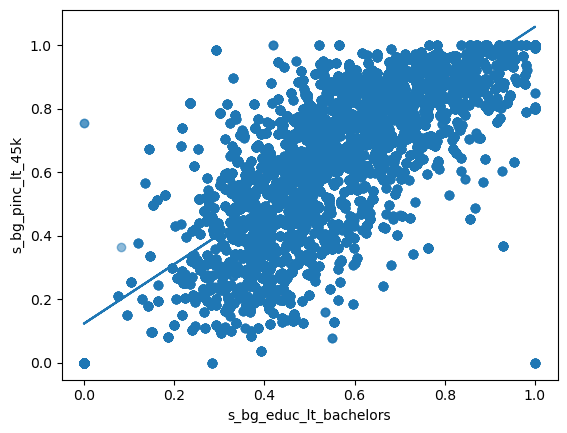

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(merge5['s_bg_pinc_lt_45k'], merge5['s_bg_educ_lt_bachelors'],  alpha=0.5)

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(merge5['s_bg_pinc_lt_45k'],  merge5['s_bg_educ_lt_bachelors'], 1)

#add linear regression line to scatterplot 
x_pinc_lt_45k=merge5['s_bg_pinc_lt_45k']
plt.plot(merge5['s_bg_pinc_lt_45k'], m*x_pinc_lt_45k+b)
plt.xlabel("s_bg_educ_lt_bachelors")
plt.ylabel("s_bg_pinc_lt_45k")
plt.show()

### 10. check correlation between income and age

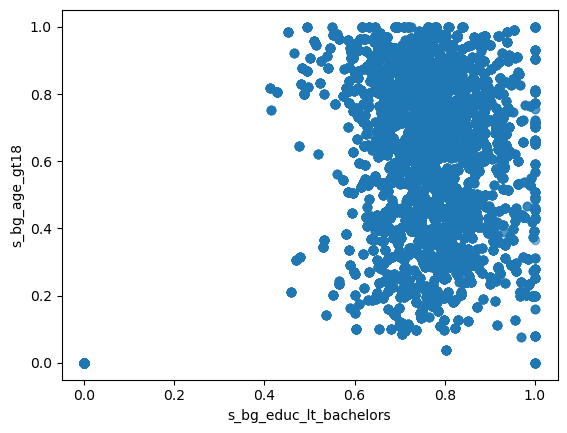

In [33]:
plt.scatter(merge5['s_bg_age_gt18'], merge5['s_bg_educ_lt_bachelors'],  alpha=0.5)
plt.xlabel("s_bg_educ_lt_bachelors")
plt.ylabel("s_bg_age_gt18")
plt.show()

#age correlation is low with other two vars.

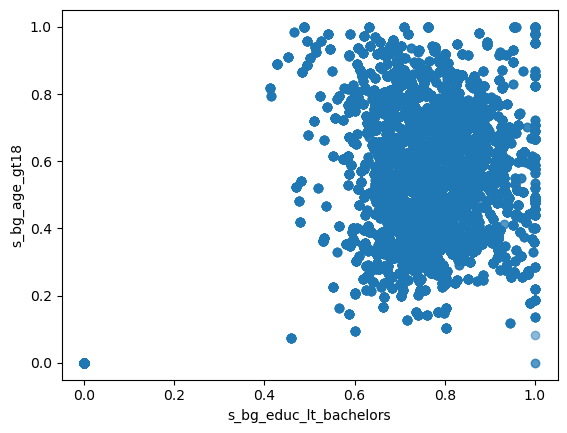

In [34]:
plt.scatter(merge5['s_bg_age_gt18'], merge5['s_bg_pinc_lt_45k'],  alpha=0.5)
plt.xlabel("s_bg_educ_lt_bachelors")
plt.ylabel("s_bg_age_gt18")
plt.show()

#age correlation is low with other two vars.

### 11. Adjustment to the high correlation between educ and income based on eq (1)

In [35]:
from sklearn.linear_model import LinearRegression


merge5 = merge5.dropna(axis=0)
# Create a numpy array of data:
x = np.array(merge5['s_bg_pinc_lt_45k']).reshape((-1, 1))
y = np.array(merge5['s_bg_educ_lt_bachelors'])
#run bivariate linear regression
regr =  LinearRegression()
results=regr.fit(x,y)

# Make adjustment index (predicted y) based on equation (1)
merge5['y_pred'] = regr.predict(x).reshape((-1, 1))

print("Coefficients: \n", regr.coef_) # coefficient of 0.93 suggest high correlation between the two variables.
print("predicted y: \n", merge5['y_pred'].mean())
print("y: \n", y.mean())
print("x: \n", x.mean())


Coefficients: 
 [0.93413271]
predicted y: 
 0.6324534969310122
y: 
 0.632453496931012
x: 
 0.5446789080033402


#### replace predicted value to 1 if y_pred>1, because a fraction can't go over 1.

In [36]:
merge5.loc[merge5.y_pred > 1, 'y_pred'] = 1


#### As shown in the graph below, it is basically addition of intercept and slope*\%income to the original \%income data. The mean of y_pred is 0.63, while the original mean of \%income is 0.54. I propose to use y_pred instead of s_bg_pinc_lt_45k in calculating the joint density.

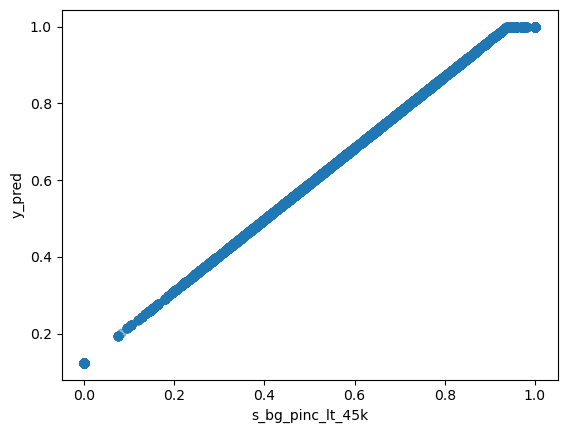

s_bg_pinc_lt_45k: 
 0.5446789080033402
y_pred: 
 0.6318152678099239


In [37]:
plt.scatter(merge5['s_bg_pinc_lt_45k'], merge5['y_pred'],  alpha=0.5)
plt.xlabel("s_bg_pinc_lt_45k")
plt.ylabel("y_pred")
plt.show()
print("s_bg_pinc_lt_45k: \n", merge5['s_bg_pinc_lt_45k'].mean())
print("y_pred: \n", merge5['y_pred'].mean())

### 12. Revision of joint density, call it s_joint_age_educ_inc_adj

In [38]:

# joint probability age*educ*income of target population (using y_pred)
merge5['s_joint_age_educ_inc_adj']=merge5['s_bg_age_gt18']*merge5['s_bg_educ_lt_bachelors']*merge5['y_pred']

# block-level estimate of target population
merge5['b_target_pop_adj']=merge5['b_population']*merge5['s_joint_age_educ_inc_adj']

# calculating density and distribution per sq miles
merge5['target_density_adj']=(merge5['b_target_pop_adj'] / whole_population_6_counties).fillna(0)
merge5['target_pop_per_sq_mile_adj']=merge5['b_target_pop_adj'] / (merge5['shape_area'] / whole_area_6_counties)



### 13. After the adjustment for correlation between income and education, joint density changes from 0.29 to 0.33

In [39]:

print("s_joint_age_educ_inc: \n", merge5['s_joint_age_educ_inc'].mean())
print("s_joint_age_educ_inc_adj: \n", merge5['s_joint_age_educ_inc_adj'].mean())
merge5.info()


s_joint_age_educ_inc: 
 0.29059760078943736
s_joint_age_educ_inc_adj: 
 0.3308518894458803
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37701 entries, 0 to 37700
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   b_gisjoin                   37701 non-null  object 
 1   state                       37701 non-null  object 
 2   county                      37701 non-null  object 
 3   b_population                37701 non-null  int64  
 4   fid                         37701 non-null  int32  
 5   shape_area                  37701 non-null  float32
 6   bg_gisjoin                  37701 non-null  object 
 7   bg_age_gt18                 37701 non-null  int64  
 8   s_bg_age_gt18               37701 non-null  float64
 9   bg_educ_lt_bachelors        37701 non-null  int64  
 10  bg_inc_lt_45000             37701 non-null  int64  
 11  s_bg_educ_lt_bachelors      37701 non-null  float64
 1

In [40]:
final_block_data=merge5[['fid', 'county' ,'bg_gisjoin' ,'b_gisjoin' ,'b_population', 'bg_age_gt18', 'bg_educ_lt_bachelors', 'bg_inc_lt_45000','s_bg_age_gt18', 's_bg_educ_lt_bachelors', 's_bg_inc_lt_45000', 's_joint_age_educ_inc' ,'b_target_pop', 'target_pop_per_sq_mile', 'target_density', 's_joint_age_educ_inc_adj' ,'b_target_pop_adj', 'target_pop_per_sq_mile_adj', 'target_density_adj']]
final_block_data

,fid,county,bg_gisjoin,b_gisjoin,b_population,bg_age_gt18,bg_educ_lt_bachelors,bg_inc_lt_45000,s_bg_age_gt18,s_bg_educ_lt_bachelors,s_bg_inc_lt_45000,s_joint_age_educ_inc,b_target_pop,target_pop_per_sq_mile,target_density,s_joint_age_educ_inc_adj,b_target_pop_adj,target_pop_per_sq_mile_adj,target_density_adj
0,0,Johnson County,G20009100500001,G20009100500001000,52,480,237,130,0.914286,0.697059,0.546218,0.498382,25.915841,2412.201467,0.000013,0.544359,28.306653,2634.734136,0.000014
1,1,Johnson County,G20009100500001,G20009100500001001,47,480,237,130,0.914286,0.697059,0.546218,0.498382,23.423933,2254.971812,0.000012,0.544359,25.584860,2462.999584,0.000013
2,2,Johnson County,G20009100500001,G20009100500001002,51,480,237,130,0.914286,0.697059,0.546218,0.498382,25.417459,2494.954108,0.000013,0.544359,27.762294,2725.120951,0.000014
3,3,Johnson County,G20009100500001,G20009100500001003,58,480,237,130,0.914286,0.697059,0.546218,0.498382,28.906130,2765.100132,0.000015,0.544359,31.572805,3020.188740,0.000016
4,4,Johnson County,G20009100500001,G20009100500001004,138,480,237,130,0.914286,0.697059,0.546218,0.498382,68.776654,2391.340569,0.000035,0.544359,75.121503,2611.948759,0.000038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37696,37696,Platte County,G29016509800001,G29016509800001121,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
37697,37697,Platte County,G29016509800001,G29016509800001122,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
37698,37698,Platte County,G29016509800001,G29016509800001123,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
37699,37699,Platte County,G29016509800001,G29016509800001124,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 14. save final output file

In [175]:
final_block_data.to_excel("G:\\My Drive\\0.SWB\\SWB211/intermediate_data/block_level_target_population_outofpython_20230414.xlsx",index=False)
final_block_data.to_csv("G:\\My Drive\\0.SWB\\SWB211/intermediate_data/block_level_target_population_outofpython_20230414.csv",index=False)